In [2]:
import tensorflow as tf
tf.__version__

'2.12.0'

In [3]:
# Import The Libraries
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras import layers, Sequential
import numpy as np
import sklearn


In [5]:
# directories
weights_directory = "..\classification\weights"
results_directory = "..\classification\\results"
path_dataset_men = "..\dataset_classificazione\men"
path_dataset_women = "..\dataset_classificazione\women"

In [6]:
# Set Resize variable
IMAGE_SIZE = (224, 224)

In [27]:
''' Arguments:
    - include_top: whether to include the fully-connected layer at the top of the network.
    - weights: 'imagenet' (pre-training on ImageNet)
    - input_tensor: optional Keras tensor to use as image input for the model.
    - input_shape: optional shape tuple, only to be specified if include_top is False (otherwise the input      shape has to be (224, 224, 3)
    - pooling: Optional pooling mode for feature extraction when include_top is False.
            None means that the output of the model will be the 4D tensor output of the last convolutional block.
            avg means that global average pooling will be applied to the output of the last convolutional block, and thus the output of the model will be a 2D tensor.
            max means that global max pooling will be applied.
    - classes: optional number of classes to classify images into, only to be specified if include_top is True,     and if no weights argument is specified.
    - classifier_activation: The activation function to use on the "top" layer.
'''

resnet = ResNet50(
    input_shape = (224,224,3), # Making the image into 3 Channel
    weights = 'imagenet',
    include_top = False,
    pooling = 'avg'
)

In [28]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [29]:
# Freeze the layers except the last 4 layers
for layer in resnet.layers:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in resnet.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x0000021142DFB650> False
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x00000211430A7B10> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000002113E421AD0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000021100F282D0> False
<keras.layers.core.activation.Activation object at 0x000002114536A110> False
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x000002113E5083D0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000021145288250> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x00000211015928D0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000002110147CAD0> False
<keras.layers.core.activation.Activation object at 0x0000021101594DD0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000002113E763BD0> False
<keras.layers.normalization.batch_normalization.BatchNormalization obj

In [30]:
# Create a model Object
model = tf.keras.models.Sequential()
model.add(resnet)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(10, activation='softmax'))

In [39]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_9 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 10)               

In [32]:
import os
import cv2

# Codice per ottenere il path delle immagini da classificare

imgs_list_men = [os.path.join(path_dataset_men, img_name) for img_name in os.listdir(path_dataset_men)]
imgs_list_women = [os.path.join(path_dataset_women, img_name) for img_name in os.listdir(path_dataset_women)]
imgs_list = imgs_list_men + imgs_list_women

print("Numero totale immagini: " + str(len(imgs_list)))

imgs_array = []
for file_path in imgs_list:
    #print(file_path)
    img = cv2.imread(file_path)
    if img is None:
        print('Wrong path:', file_path)
    else:
        img = cv2.resize(img, IMAGE_SIZE)
        #RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs_array.append(img)

Numero totale immagini: 1402


In [33]:
import ntpath

# creazione delle etichette delle immagini
possible_materials = set()
for image_path in imgs_list:
    head, image_name = ntpath.split(image_path)
    index, brand, material = image_name.split('_')
    materials = material.split('+')
    for materiale in materials:
        possible_materials.add(materiale.split('.')[0])
list_possible_materials = list(possible_materials)

print("Numero possibili materiali: " + str(len(possible_materials)))
print(list_possible_materials)

labels = []

for image_path in imgs_list:
    head, image_name = ntpath.split(image_path)
    index, brand, material = image_name.split('_')
    materials = material.split('+')
    label = np.zeros(shape=len(possible_materials), dtype=float)
    for materiale in materials:
        materiale = materiale.split('.')[0]
        indice = list_possible_materials.index(materiale)
        label[indice] = 1
    labels.append(label)

print(str(len(labels)))

Numero possibili materiali: 10
['goat-leather', 'polyester', 'calf-leather', 'lamb-leather', 'fabric', 'canvas', 'leather', 'raffia', 'cow-leather', 'polyurethane']
1402


[[[226 221 218]
  [226 221 218]
  [226 221 218]
  ...
  [226 221 218]
  [226 221 218]
  [226 221 218]]

 [[226 221 218]
  [226 221 218]
  [226 221 218]
  ...
  [226 221 218]
  [226 221 218]
  [226 221 218]]

 [[226 221 218]
  [226 221 218]
  [226 221 218]
  ...
  [226 221 218]
  [226 221 218]
  [226 221 218]]

 ...

 [[230 227 223]
  [230 227 223]
  [230 227 223]
  ...
  [230 227 223]
  [230 227 223]
  [230 227 223]]

 [[230 227 223]
  [230 227 223]
  [230 227 223]
  ...
  [230 227 223]
  [230 227 223]
  [230 227 223]]

 [[230 227 223]
  [230 227 223]
  [230 227 223]
  ...
  [230 227 223]
  [230 227 223]
  [230 227 223]]]
..\dataset_classificazione\men\0_BALENCIAGA_leather.jpg


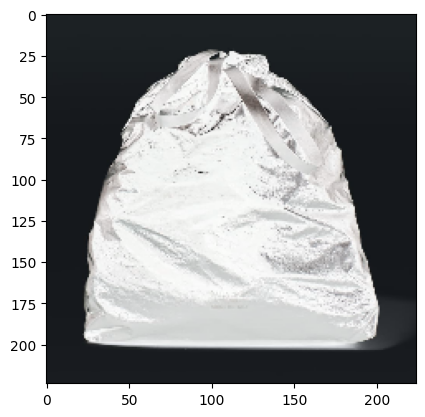

In [34]:
from matplotlib import pyplot as plt

print(imgs_array[0])
print(imgs_list[0])

imgplot = plt.imshow(255-imgs_array[1], vmin=0, vmax=255)

In [35]:
from sklearn.model_selection import train_test_split

images_array, labels_array = sklearn.utils.shuffle(imgs_array, labels, random_state=15)
Xtrain, X_test, Ytrain, Y_test = train_test_split(images_array,labels_array, test_size=0.10,  random_state=15)
X_train, X_valid, Y_train, Y_valid = train_test_split(Xtrain, Ytrain, test_size=0.2,  random_state=15)

X_train = np.asarray(X_train)
X_valid = np.asarray(X_valid)
X_test = np.asarray(X_test)
Y_train = np.asarray(Y_train)
Y_valid = np.asarray(Y_valid)
Y_test = np.asarray(Y_test)

In [37]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(os.path.join(weights_directory, "weights_resnet50_512_all_frozen_lr_0007_dropout_03.h5"),
                             verbose=1, monitor='val_loss', save_best_only=True)
model.compile(loss="categorical_crossentropy", metrics="Recall",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.007, momentum=0.9))

In [38]:
history = model.fit(np.asarray(X_train), np.asarray(Y_train), epochs=40, batch_size=32, validation_data=(X_valid, Y_valid), verbose=1, callbacks=[checkpoint], shuffle=True)

Epoch 1/40
32/32 [==============================] - ETA: 0s - loss: 2.0123 - recall: 0.1429
Epoch 1: val_loss improved from inf to 1.48063, saving model to ..\classification\weights\weights_resnet50_512_all_frozen_lr_0007_dropout_03.h5
32/32 [==============================] - 175s 5s/step - loss: 2.0123 - recall: 0.1429 - val_loss: 1.4806 - val_recall: 0.3241
Epoch 2/40
32/32 [==============================] - ETA: 0s - loss: 1.5437 - recall: 0.2133
Epoch 2: val_loss improved from 1.48063 to 1.34947, saving model to ..\classification\weights\weights_resnet50_512_all_frozen_lr_0007_dropout_03.h5
32/32 [==============================] - 147s 4s/step - loss: 1.5437 - recall: 0.2133 - val_loss: 1.3495 - val_recall: 0.3794
Epoch 3/40
32/32 [==============================] - ETA: 0s - loss: 1.4275 - recall: 0.2341
Epoch 3: val_loss improved from 1.34947 to 1.28893, saving model to ..\classification\weights\weights_resnet50_512_all_frozen_lr_0007_dropout_03.h5
32/32 [=========================

In [40]:
import pandas as pd
history_ = pd.DataFrame(history.history)
with open(os.path.join(results_directory, "history_resnet50_512_all_frozen_lr_0007_dropout_03.json"), "w") as json_file:
    history_.to_json(json_file)

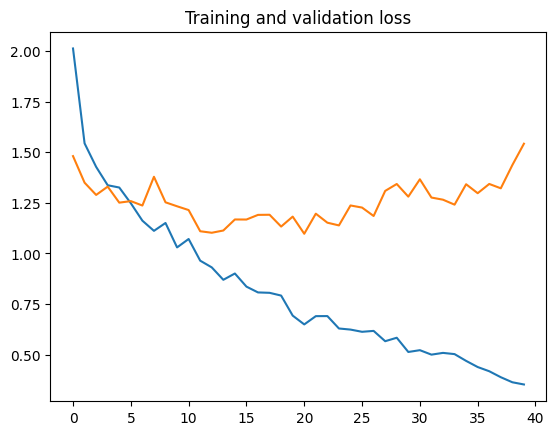

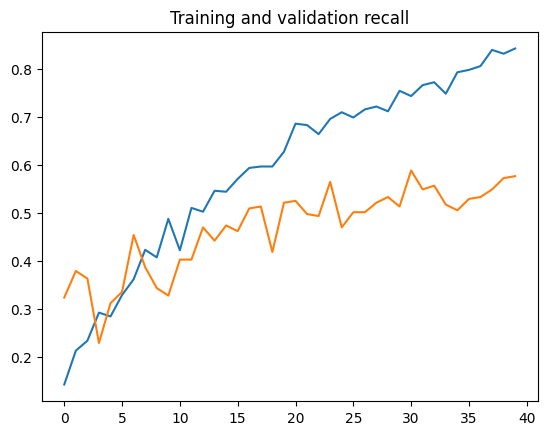

In [41]:
epochs = 40
plt.figure()
plt.title('Training and validation loss')
plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")

plt.figure()
plt.title('Training and validation recall')
plt.plot(np.arange(0, epochs), history.history["recall"], label="train_rec")
plt.plot(np.arange(0, epochs), history.history["val_recall"], label="val_rec")

In [ ]:
Y_pred = model.predict(X_test)
Y_pred_binary = np.where(Y_pred>0.5, 1, 0)
print(sklearn.metrics.classification_report(Y_test, Y_pred_binary, target_names=list_possible_materials))

In [ ]:
supports_for_dataset = {}
print(len(labels))

for vector in labels:
    label = ''
    for index, number in enumerate(vector):
        if number == 1:
            if label == '':
                label = label + list_possible_materials[index]
            else:
                label = label + '+' + list_possible_materials[index]
    try:
        supports_for_dataset[label] = supports_for_dataset[label] + 1
    except:
        supports_for_dataset[label] = 1

print(supports_for_dataset)
